In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten


from statsmodels.tools.eval_measures import rmse

import numpy as np

Using TensorFlow backend.


In [2]:
ebola = pd.read_csv('../data/ebola-cases/ebola.csv')

In [3]:
ebola.head(15)

,Indicator,Country,Date,value
0,"Cumulative number of confirmed, probable and s...",Guinea,2015-03-10,3285.0
1,Cumulative number of confirmed Ebola cases,Guinea,2015-03-10,2871.0
2,Cumulative number of probable Ebola cases,Guinea,2015-03-10,392.0
3,Cumulative number of suspected Ebola cases,Guinea,2015-03-10,22.0
4,"Cumulative number of confirmed, probable and s...",Guinea,2015-03-10,2170.0
5,Cumulative number of confirmed Ebola deaths,Guinea,2015-03-10,1778.0
6,Cumulative number of probable Ebola deaths,Guinea,2015-03-10,392.0
7,"Cumulative number of confirmed, probable and s...",Liberia,2015-03-10,9343.0
8,Cumulative number of confirmed Ebola cases,Liberia,2015-03-10,3150.0
9,Cumulative number of probable Ebola cases,Liberia,2015-03-10,1879.0


In [4]:
ebola = ebola[["Country", "Date", "value"]]

In [5]:
countries = list(ebola["Country"].unique())
countries

['Guinea',
 'Liberia',
 'Sierra Leone',
 'United Kingdom',
 'Mali',
 'Nigeria',
 'Senegal',
 'Spain',
 'United States of America',
 'Italy',
 'Liberia 2',
 'Guinea 2']

West African Countries suffered the worst for the outbreak, so let's take a look at that. 

Let's also sum up values for each date 

In [6]:
cols = ["Country", "Date"]

nigeria = ebola.loc[ebola["Country"] == "Nigeria"]
nigeria = nigeria.groupby(cols, as_index=False).value.sum()
nigeria = nigeria.reset_index(drop=True)

guinea = ebola.loc[ebola["Country"] == "Guinea"]
guinea = guinea.groupby(cols, as_index=False).value.sum()
guinea = guinea.reset_index(drop=True)

liberia = ebola.loc[ebola["Country"] == "Liberia"]
liberia = liberia.groupby(cols, as_index=False).value.sum()
liberia = liberia.reset_index(drop=True)

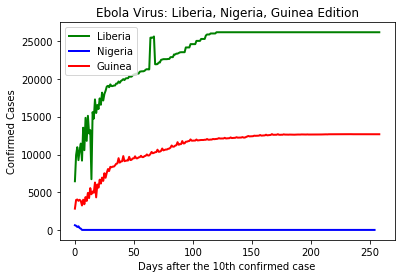

In [7]:
china_line = plt.plot(liberia.index, liberia['value'], 'g', linewidth = 2, label="Liberia")
us_line = plt.plot(nigeria.index, nigeria['value'],'b',linewidth = 2, label="Nigeria")
italy_line = plt.plot(guinea.index, guinea['value'],'r',linewidth = 2, label="Guinea")
plt.title("Ebola Virus: Liberia, Nigeria, Guinea Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

In [8]:
liberia = liberia.drop(["Country"],axis=1)
nigeria = nigeria.drop(["Country"],axis=1)
guinea = guinea.drop(["Country"],axis=1)


liberia.Date = pd.to_datetime(liberia.Date)
nigeria.Date = pd.to_datetime(nigeria.Date)
guinea.Date = pd.to_datetime(guinea.Date)

liberia = liberia.set_index("Date")
nigeria = nigeria.set_index("Date")
guinea = guinea.set_index("Date")

train_data_liberia = liberia[:len(liberia)-51]
test_data_liberia = liberia[len(liberia)-51:]
train_data_nigeria = nigeria[:len(nigeria)-51]
test_data_nigeria = nigeria[len(nigeria)-51:]
train_data_guinea = guinea[:len(guinea)-51]
test_data_guinea = guinea[len(guinea)-51:]

In [9]:
scaler = MinMaxScaler()
scaler.fit(train_data_liberia)
scaled_train_data = scaler.transform(train_data_liberia)
scaled_test_data = scaler.transform(test_data_liberia)

In [10]:
n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [11]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
201/201 [==============================] - 1s 6ms/step - loss: 0.0570
Epoch 2/20
201/201 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 3/20
201/201 [==============================] - 1s 5ms/step - loss: 0.0030
Epoch 4/20
201/201 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 5/20
 55/201 [=======>......................] - ETA: 1s - loss: 0.0025

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);


In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_liberia)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

In [ ]:
test_data_liberia['LSTM_Predictions'] = lstm_predictions
test_data_liberia


test_data_liberia['value'].plot(figsize = (16,5), legend=True)
test_data_liberia['LSTM_Predictions'].plot(legend = True);



lstm_rmse_error_liberia = rmse(test_data_liberia['value'], test_data_liberia["LSTM_Predictions"])
lstm_mse_error_liberia = lstm_rmse_error_liberia**2
mean_value = liberia['value'].mean()


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data_nigeria)
scaled_train_data = scaler.transform(train_data_nigeria)
scaled_test_data = scaler.transform(test_data_nigeria)


In [ ]:
n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);


lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_nigeria)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions


In [ ]:
test_data_nigeria['LSTM_Predictions'] = lstm_predictions
test_data_nigeria


test_data_nigeria['value'].plot(figsize = (16,5), legend=True)
test_data_nigeria['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error_nigeria = rmse(test_data_nigeria['value'], test_data_nigeria["LSTM_Predictions"])
lstm_mse_error_nigeria = lstm_rmse_error_nigeria**2
mean_value = nigeria['value'].mean()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data_guinea)
scaled_train_data = scaler.transform(train_data_guinea)
scaled_test_data = scaler.transform(test_data_guinea)


In [ ]:
n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_guinea)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)


test_data_guinea['LSTM_Predictions'] = lstm_predictions

test_data_guinea['value'].plot(figsize = (16,5), legend=True)
test_data_guinea['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error_guinea = rmse(test_data_guinea['value'], test_data_guinea["LSTM_Predictions"])
lstm_mse_error_guinea = lstm_rmse_error_guinea**2
mean_value = guinea['value'].mean()

In [ ]:
from tabulate import tabulate

print(tabulate([
    ['Liberia LSTM Errors', lstm_mse_error_liberia, lstm_rmse_error_liberia], 
    ['Nigeria Arabia LSTM Errors', lstm_mse_error_nigeria, lstm_rmse_error_nigeria],
    ['Guinea LSTM Errors', lstm_mse_error_guinea, lstm_rmse_error_guinea]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))


